In [1]:
import sys
import fil_finder
from fil_finder import FilFinder2D, Filament2D
from astropy.io import fits
import copy
%matplotlib inline
import matplotlib.pyplot as plt
import astropy.units as u

# Optional settings for the plots. Comment out if needed.
# import seaborn as sb
# sb.set_context('poster')

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12., 9.6)
from astropy.wcs import WCS
import numpy as np
from spectral_cube import Projection
import aplpy

In [2]:
def v2ch(v, w): # v(km/s)をchに変える
    x_tempo, y_tempo, v_tempo   = w.wcs_pix2world(0, 0, 0, 0)
    x_ch, y_ch, v_ch   = w.wcs_world2pix(x_tempo, y_tempo, v*1000.0, 0)
    v_ch = int(round(float(v_ch), 0))
    return v_ch

def del_header_key(header, keys): # headerのkeyを消す
    import copy
    h = copy.deepcopy(header)
    for k in keys:
        try:
            del h[k]
        except:
            pass
    return h
def make_new_hdu_integ(hdu, v_start_wcs, v_end_wcs, w): # 積分強度のhduを作る
    data = hdu.data
    header = hdu.header
    start_ch, end_ch = v2ch(v_start_wcs, w), v2ch(v_end_wcs, w)
    new_data = np.nansum(data[start_ch:end_ch+1], axis=0)*np.abs(header["CDELT3"])/1000.0
    header = del_header_key(header, ["CRVAL3", "CRPIX3", "CRVAL3", "CDELT3", "CUNIT3", "CTYPE3", "CROTA3", "NAXIS3", "CNAME3"])
    header["NAXIS"] = 2
#     header["CTYPE1"] = "GLON-CAR"
#     header["CTYPE2"] = "GLAT-CAR"
    new_data[new_data==0.0]=np.nan
    try:
        header["WCSAXES"] = 2
    except:
        pass
    new_hdu = fits.PrimaryHDU(new_data, header)
    return new_hdu

In [3]:
hdu = fits.open("/home/filament/Downloads/fil_remake/-50_-20.fits")[0]

In [4]:
# hdu = fits.open("/home/filament/Downloads/important/hspirepmw_30pxmp_0436_p2515_1476896819298.fits")[1]

In [5]:
hdu.data.shape

(2640, 5081)

In [10]:

#################################
# hdu.header["CUNIT1"] = "deg"
# hdu.header["CUNIT2"] = "deg"
# hdu.header["BPA"] = 0.0
# hdu.header["BMAJ"] = 0.2706
# hdu.header["BMIN"] = 0.2706
# hdu.header["LONPOLE"] = 0.0
# hdu.header["LATPOLE"] = 90.0

##################################

In [7]:
w = WCS(hdu)

In [8]:
# integ_hdu = make_new_hdu_integ(hdu, -50, -20, w)
# integ_hdu.data[integ_hdu.data<=0.01]=np.nan  ####0.01
# hdr1 = fits.PrimaryHDU().header
# hdr1["BITPIX"] = integ_hdu.header["BITPIX"]
# hdr1["NAXIS"] = integ_hdu.header["NAXIS"]
# hdr1["NAXIS1"] = integ_hdu.header["NAXIS1"]
# hdr1["NAXIS2"] = integ_hdu.header["NAXIS2"]
# # hdr1["CDELT1"] = integ_hdu.header["CDELT1"]
# # hdr1["CDELT2"] = integ_hdu.header["CDELT2"]
# hdr1["CDELT1"] = -cdelt
# hdr1["CDELT2"] = cdelt
# hdr1["CRVAL1"] = integ_hdu.header["CRVAL1"]
# hdr1["CRVAL2"] = integ_hdu.header["CRVAL2"]
# hdr1["CRPIX1"] = integ_hdu.header["CRPIX1"]
# hdr1["CRPIX2"] = integ_hdu.header["CRPIX2"]
# hdr1["CTYPE1"] = integ_hdu.header["CTYPE1"]
# hdr1["CTYPE2"] = integ_hdu.header["CTYPE2"]
# hdr1["CUNIT1"] = integ_hdu.header["CUNIT1"]
# hdr1["CUNIT2"] = integ_hdu.header["CUNIT2"]

In [11]:
fil = FilFinder2D(hdu, distance=10 * u.pc, beamwidth=hdu.header["BMAJ"]* u.deg)

TypeError: Input data is not of an accepted form:['numpy.ndarray', 'astropy.io.fits.PrimaryHDU', 'spectral_cube.Projection', 'spectral_cube.Slice', 'astropy.units.Quantity']

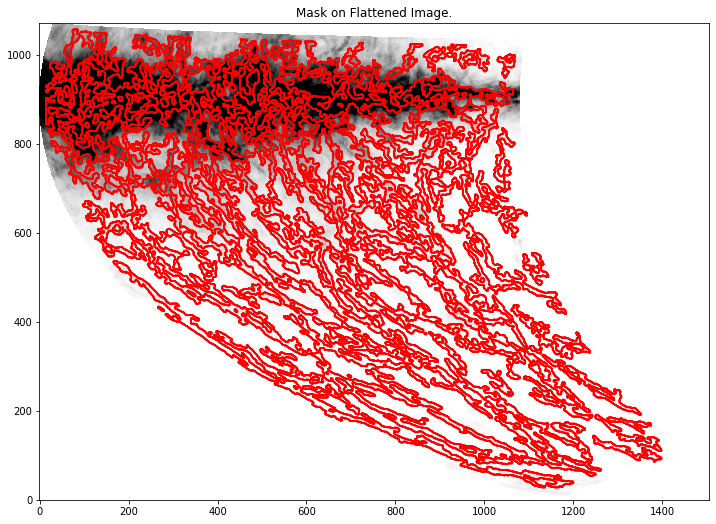

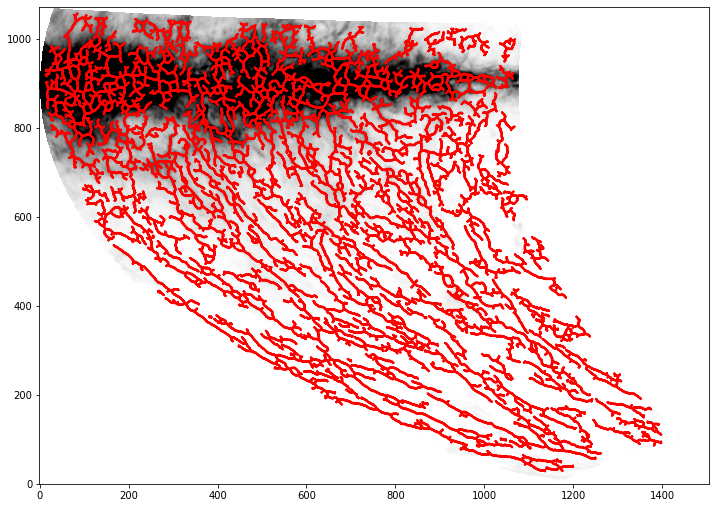

In [104]:
fil.preprocess_image(flatten_percent=95)
fil.create_mask(verbose=True)
fil.medskel(verbose=True)
fil_skeleton= fil.skeleton
fil_skeleton = fil_skeleton.astype("int")


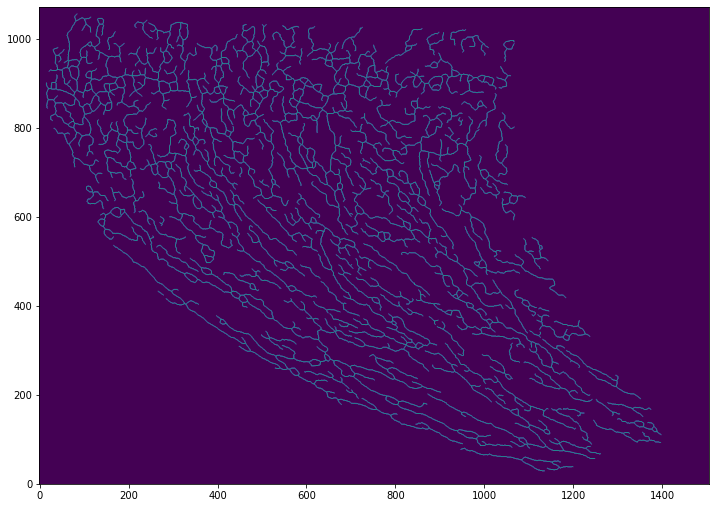

In [29]:
plt.imshow(fil.skeleton,origin='lower')

In [13]:
fil.analyze_skeletons()
fil.exec_rht()

/home/filament/.pyenv/versions/3.7.11/envs/fil_project/lib/python3.7/site-packages/fil_finder/filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


In [17]:
fil.filaments[0].position()

[<Quantity 53. pix>, <Quantity 1101. pix>]

In [24]:
ori = []
for f in fil.filaments:
    ori.append(np.rad2deg(f.orientation))

In [38]:
ori[0].value

80.14252089412082

In [95]:
print(fil.filaments[0].position())

[<Quantity 53. pix>, <Quantity 1101. pix>]


In [82]:
print(fil.filaments[0].branch_properties['pixels'][0][0])

[  2 184]


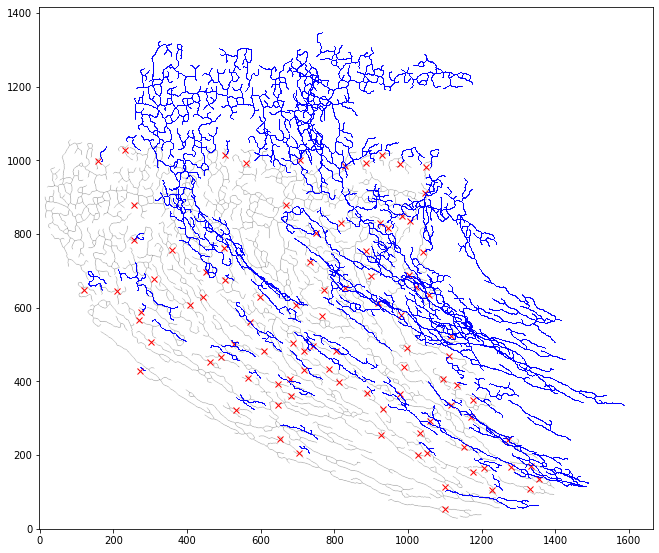

In [98]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(fil.skeleton,origin="lower",cmap="Greys")
for f in fil.filaments:
    ax.plot(f.position()[1],f.position()[0],color="red",marker="x")
for t in range(95):
    for i in fil.filaments[t].branch_pts():
        for j in i:
            ax.plot(j[1]+fil.filaments[t].position()[1].value,j[0]+fil.filaments[t].position()[0].value,color="b",marker="x",markersize=0.3)
        
        


In [33]:
fil.branch_properties['pixels']

[[array([[  2, 184],
         [  2, 185],
         [  2, 186],
         [  2, 187],
         [  2, 188],
         [  2, 189],
         [  3, 179],
         [  3, 180],
         [  3, 181],
         [  3, 182],
         [  3, 183],
         [  4, 175],
         [  4, 176],
         [  4, 177],
         [  4, 178],
         [  5, 173],
         [  5, 174],
         [  6, 171],
         [  6, 172],
         [  7, 169],
         [  7, 170],
         [  8, 167],
         [  8, 168],
         [  9, 166],
         [ 10, 165],
         [ 11, 163],
         [ 11, 164],
         [ 12, 162],
         [ 13, 160],
         [ 13, 161],
         [ 14, 158],
         [ 14, 159],
         [ 15, 156],
         [ 15, 157],
         [ 16, 155],
         [ 17, 152],
         [ 17, 153],
         [ 17, 154],
         [ 18, 149],
         [ 18, 150],
         [ 18, 151],
         [ 19, 147],
         [ 19, 148],
         [ 20, 145],
         [ 20, 146],
         [ 21, 144],
         [ 22, 142],
         [ 22

In [39]:
pa_deg_map = np.zeros(hdu.data.shape)

95

In [53]:
hdu.data.shape

(1072, 1505)

In [55]:
len(fil.branch_properties['number'])

95

In [57]:
fil.branch_properties['number']

array([  7,  30, 187,   5,   3,   9,  13,   3,   3,   3,   3,   3,   7,
         7,   5,   3,  58,   5,   6,   5,   1,   3,   5,  16,   3,  15,
         3,   3,   6,   3,   5,   3,   1,   8,   3,   7,   3,  29,   1,
         1,   4,   5,   1,   9,  10,   3,   1,   3,  10,   3,  43,   7,
        12,   5,   9,  27,  36, 214,   3,   8,   3,   3,   1,   4,   7,
       385,   4,  11,  50,   3,  18,   6,   3,   1,   5,   3,   1,   3,
        14,   3,   3,   3,   3,   4,   5,  13,   6,   3,   5,   3,   3,
         1,   1,   3,   3])

In [56]:
len(fil.branch_properties['number'][0])

TypeError: object of type 'numpy.int64' has no len()

In [51]:
for pos,d in zip(fil.branch_properties['pixels'],ori):
    for pospos in pos:
        for i in pospos:
            pa_deg_map[i[1],i[0]]=d.value
            
        
#         pa_deg_map[i[0],i[1]]=d

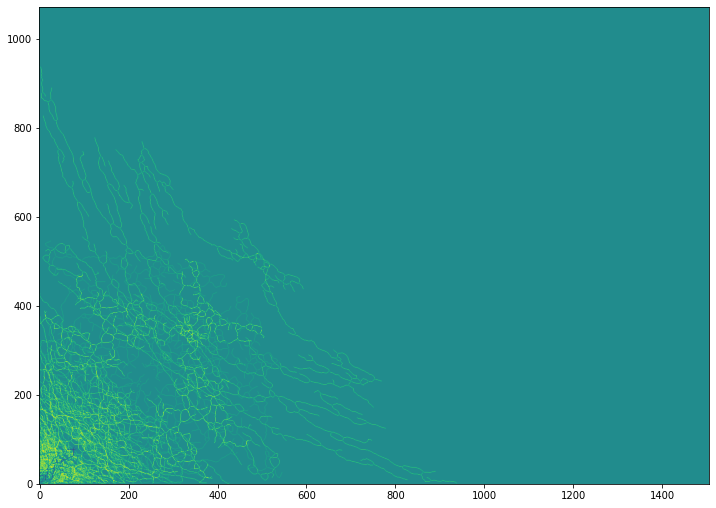

In [58]:
plt.imshow(pa_deg_map,origin='lower')

/home/filament/.pyenv/versions/3.7.11/envs/fil_project/lib/python3.7/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence.

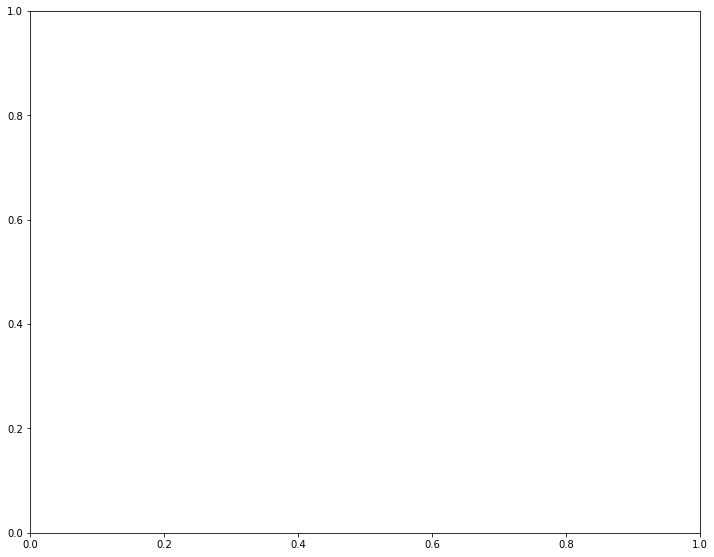

In [61]:
plt.plot(fil.branch_properties['pixels'][0])

In [ ]:
plt.plot(fil0.position()[1],fil0.position()[0],color="red",marker="x")
plt.plot(fil1.position()[1],fil1.position()[0],color="m",marker="x")
plt.plot(fil2.position()[1],fil2.position()[0],color="g",marker="x")
plt.plot(fil3.position()[1],fil3.position()[0],color="b",marker="x")